# Step #1 Load Packages and Data

In [16]:
# Work in progress!
# A tutorial for this file will soon be available at www.relataly.com

# Tested with Python 3.9.13, Matplotlib 3.5.2, Seaborn 0.11.2, numpy 1.21.5, plotly 4.1.1, cryptocompare 0.7.6

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})
import cryptocompare as cc
import requests
import IPython
import yaml
import json

# Set the API Key from a yaml file
yaml_file = open('API Keys/api_config_cryptocompare.yml', 'r')  
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key'] 
# alternatively if you have not stored your API key in a separate file
# api_key = your key

# Number of past days for which we retrieve data
data_limit = 2000

# Define coin symbols
symbol_a = 'BTC'
symbol_b = 'ETH'


In [2]:
# Query price data

# Generic function for an API call to a given URL
def api_call(url):
  # Set API Key as Header
  headers = {'authorization': 'Apikey ' + api_key,}
  session = requests.Session()
  session.headers.update(headers)

  # API call to cryptocompare
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  return df

def prepare_pricedata(df):
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
  return df

# Load the price data
base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
df_a = api_call(f'{base_url}{symbol_a}&tsym=USD&limit={data_limit}')
coin_a_price_df = prepare_pricedata(df_a)
df_b = api_call(f'{base_url}{symbol_b}&tsym=USD&limit={data_limit}')
coin_b_price_df = prepare_pricedata(df_b)
coin_b_price_df.head(3)

,high,low,open,volumefrom,volumeto,close,date
0,399.50,359.70,394.66,681665.87,2.601237e+08,388.09,2017-06-13
1,393.62,317.23,388.09,973146.95,3.482125e+08,343.84,2017-06-14
2,351.94,260.78,343.84,1945808.20,6.021127e+08,344.68,2017-06-15


In [15]:
# Query on-chain data

# Prepare the onchain dataframe
def prepare_onchain_data(df):
  # replace the timestamp with a data and filter some faulty values
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns='time', inplace=True)
  df = df[df['hashrate'] > 0.0]
  return df
  
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
onchain_symbol_a_df = api_call(f'{base_url}{symbol_a}&limit={data_limit}')
onchain_symbol_b_df = api_call(f'{base_url}{symbol_b}&limit={data_limit}')

# Filter some faulty values
onchain_symbol_a_df = onchain_symbol_a_df[onchain_symbol_a_df['hashrate'] > 0.0]
onchain_symbol_a_df.head(3)

,id,symbol,time,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
0,1182,BTC,1497312000,253983157,272086038,425666,771394,291776,231672146,14824,11.422557,471161,4.827433e+06,6.787601e+11,603.892857,977147,1.638951e+07
1,1182,BTC,1497398400,254346501,272493345,407307,746991,287644,231959790,14442,11.357350,471301,4.743244e+06,6.787601e+11,614.611511,969356,1.639126e+07
2,1182,BTC,1497484800,254752532,272903387,410042,799478,293141,232252931,12012,10.460583,471454,5.130348e+06,6.787601e+11,568.236842,994383,1.639318e+07


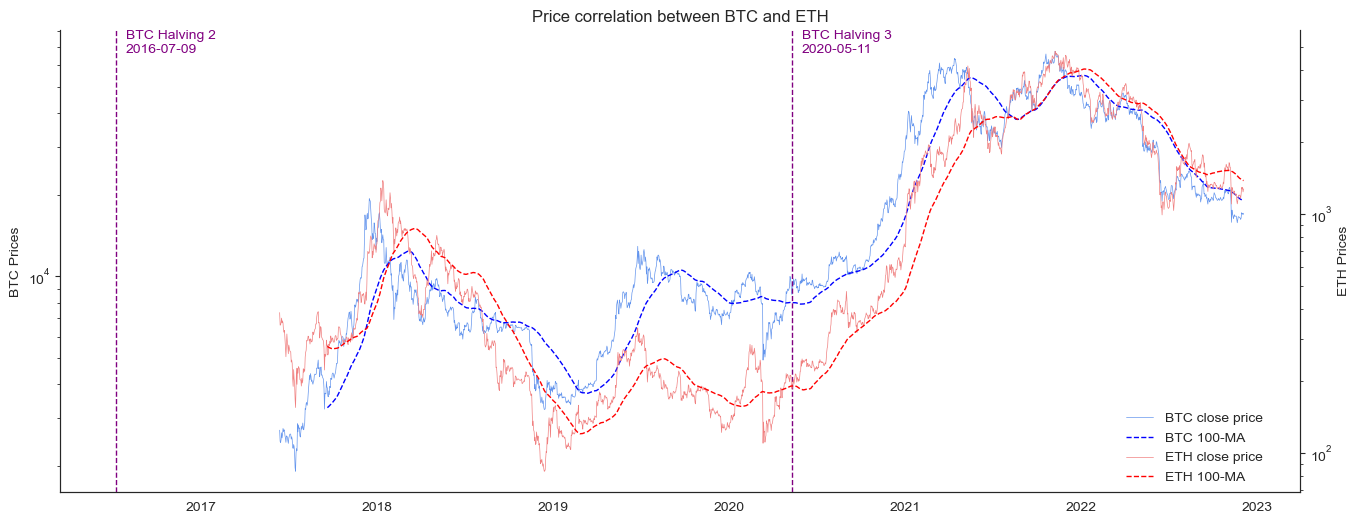

In [4]:
# Lineplot: Price Correlation with Bitcoin

# Adding moving averages
window = 100
coin_a_price_df['close_avg'] = coin_a_price_df['close'].rolling(window=window).mean() 
coin_b_price_df['close_avg'] = coin_b_price_df['close'].rolling(window=window).mean() 

# This function adds bitcoin halving dates as vertical lines
def add_halving_dates(ax, df_x_dates, df_ax1_y):
    halving_dates = ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-03-12', '2028-06-01'] 
    dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in halving_dates]
    for i, datex in enumerate(dates_list):
        halving_ts = pd.Timestamp(datex)
        x_max = df_x_dates.max() + timedelta(days=365)
        x_min = df_x_dates.min() - timedelta(days=365)
        if (halving_ts < x_max) and (halving_ts > x_min):
            ax.axvline(x=datex, color = 'purple', linewidth=1, linestyle='dashed')
            ax.text(x=datex  + timedelta(days=20), y=df_ax1_y.max()*0.99, s='BTC Halving ' + str(i) + '\n' + str(datex), color = 'purple')

# This function creates a nice legend for twinx plots
def add_twinx_legend(ax1, ax2, x_anchor=1.18, y_anchor=1.0):
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=1, facecolor='white', framealpha=0, bbox_to_anchor=(x_anchor, y_anchor))
    ax2.get_legend().remove()

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=coin_a_price_df, x='date', y='close', color='cornflowerblue', linewidth=0.5, label=f'{symbol_a} close price', ax=ax1)
sns.lineplot(data=coin_a_price_df, x='date', y='close_avg', color='blue', linestyle='dashed', linewidth=1.0, 
    label=f'{symbol_a} {window}-MA', ax=ax1)
ax1.set_ylabel(f'{symbol_a} Prices')
ax1.set(xlabel=None)
ax2 = ax1.twinx()
sns.lineplot(data=coin_b_price_df, x='date', y='close', color='lightcoral', linewidth=0.5, label=f'{symbol_b} close price', ax=ax2)
sns.lineplot(data=coin_b_price_df, x='date', y='close_avg', color='red', linestyle='dashed', linewidth=1.0, 
    label=f'{symbol_b} {window}-MA', ax=ax2)
ax2.set_ylabel(f'{symbol_b} Prices')
add_twinx_legend(ax1, ax2, 0.98, 0.2)
add_halving_dates(ax1, coin_a_price_df.date, coin_a_price_df.close)
ax1.set_yscale('log'), ax2.set_yscale('log')
plt.title(f'Price correlation between {symbol_a} and {symbol_b}')
plt.show()

In [5]:
# Prepare balance distribution dataframe
def prepare_balancedistribution_data(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)

  # Data cleansing
  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
df_raw = api_call(f'{base_url}{symbol_a}&limit={data_limit}')
df_distr = prepare_balancedistribution_data(df_raw)
df_distr.head(3)

,date,totalVolume,addressesCount,range
0,2017-06-13,2024.279997,10361569.0,0.0_to_0.001
1,2017-06-13,11899.435395,3140997.0,0.001_to_0.01
2,2017-06-13,86007.117500,2776807.0,0.01_to_0.1


In [6]:
# Prepare the onchain dataframe
def prepare_onchain_data(df):
  # replace the timestamp with a data and filter some faulty values
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns='time', inplace=True)
  df = df[df['hashrate'] > 0.0]
  return df

# Load onchain data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
df_a = api_call(f'{base_url}{symbol_a}&limit={data_limit}')
onchain_symbol_a_df = prepare_onchain_data(df_a)

# Load onchain data for Ethereum
df_b = api_call(f'{base_url}{symbol_b}&limit={data_limit}')
onchain_symbol_b_df = prepare_onchain_data(df_b)
onchain_symbol_b_df.head(3)

,id,symbol,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply,date
0,7605,ETH,20209190,22127749,59394,154633,277048,29236828,20952,80.979734,3868710,42.396109,694617337543533,16.383988,8806,9.246142e+07,2017-06-13
1,7605,ETH,20225185,22181175,53426,139340,247995,29484823,16295,57.509307,3874003,43.688391,713189048799357,16.324452,7942,9.248969e+07,2017-06-14
2,7605,ETH,20241259,22233605,52430,142300,257854,29742677,18522,83.212464,3879308,44.734447,728250481340703,16.279412,8191,9.251788e+07,2017-06-15


# Metric #1 Correlation with Bitcoin Price 

Text(0.5, 1.0, 'BTC-ETH correlation (rolling window=100)')

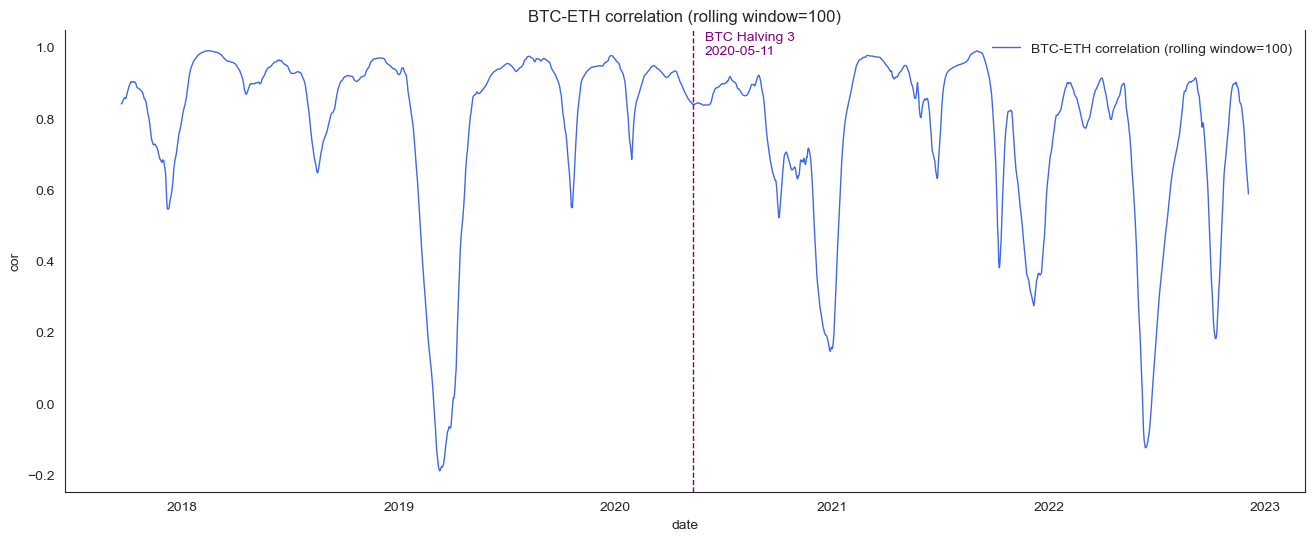

In [7]:
# Calculate the Rolling Correlation Coefficient
rolling_window = 100 #days

# Generate a work dataframe that includes closing prices and date
df_price_merged = pd.DataFrame.from_dict(data={f'close_{symbol_b}': coin_b_price_df['close'], f'close_{symbol_a}': coin_a_price_df['close'], 'date': coin_a_price_df['date']})
# Create the rolling correlation dataframe
df_temp = pd.DataFrame({'cor': coin_b_price_df.close.rolling(rolling_window).corr(coin_a_price_df.close).dropna()})
# Reverse the index and join the df to create a date index
df_cor_dateindex = df_price_merged.join(df_temp[::-1].set_index(df_temp.index)).dropna().set_index('date')

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 6))
label = f'{symbol_a}-{symbol_b} correlation (rolling window={rolling_window})'
sns.lineplot(data=df_cor_dateindex, x=df_cor_dateindex.index, y='cor', color='royalblue', linewidth=1.0, label=label)
add_halving_dates(ax1, df_cor_dateindex.index, df_cor_dateindex[f'cor'])
plt.legend(framealpha=0)
plt.title(label)

# Metric #2 Distribution by Holder Amount

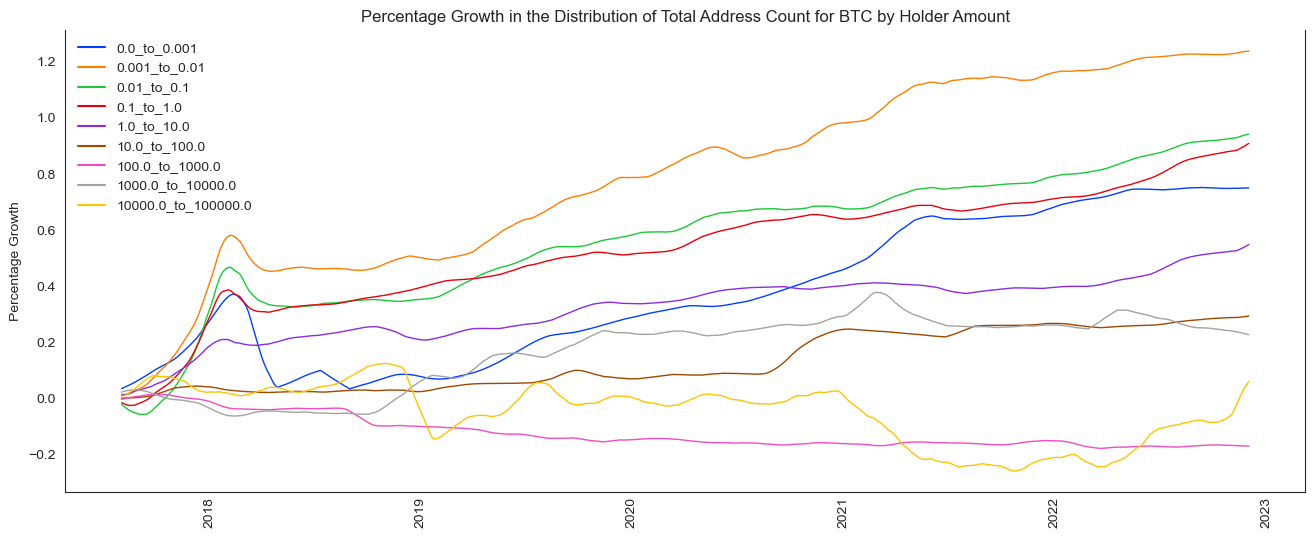

In [8]:
# Prepare address distribution data for plotting
df_distr_add = df_distr.copy()
for i in list(df_distr_add.range.unique()):
    df_distr_add.loc[df_distr.range == i, 'addressesCount_pct_cum'] = df_distr_add[df_distr_add.range == i]['addressesCount'].pct_change().dropna().cumsum().rolling(window=50).mean()
df_distr_add.dropna(inplace=True)

# Lineplot: Address Count by Holder Amount
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df_distr_add, x='date', hue='range', linewidth = 1.0, y='addressesCount_pct_cum', ax=ax1, palette='bright')
plt.ylabel('Percentage Growth')
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
plt.title(f'Percentage Growth in the Distribution of Total Address Count for {symbol_a} by Holder Amount')
plt.legend(framealpha=0)
plt.show()

# Metric #3 Difficulty vs Hashrate

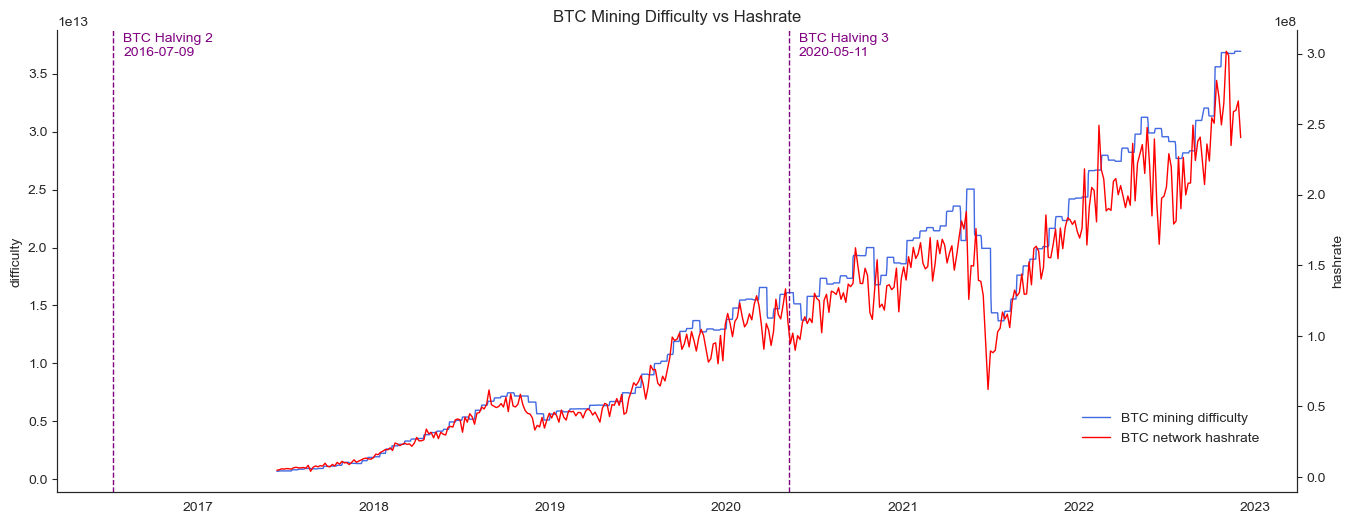

In [9]:
# Lineplot: Difficulty vs Hashrate
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df, x='date', y='difficulty', 
    linewidth=1.0, color='royalblue', ax=ax1, label=f'{symbol_a} mining difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=onchain_symbol_a_df[::5], x='date', y='hashrate', 
    linewidth=1.0, color='red', ax=ax2, label=f'{symbol_a} network hashrate')
add_twinx_legend(ax1, ax2, 0.98, 0.2)
add_halving_dates(ax1, onchain_symbol_a_df.date, onchain_symbol_a_df.difficulty)
ax1.set(xlabel=None)
plt.title(f'{symbol_a} Mining Difficulty vs Hashrate')
plt.show()

# Metric #4 Difficulty vs Price

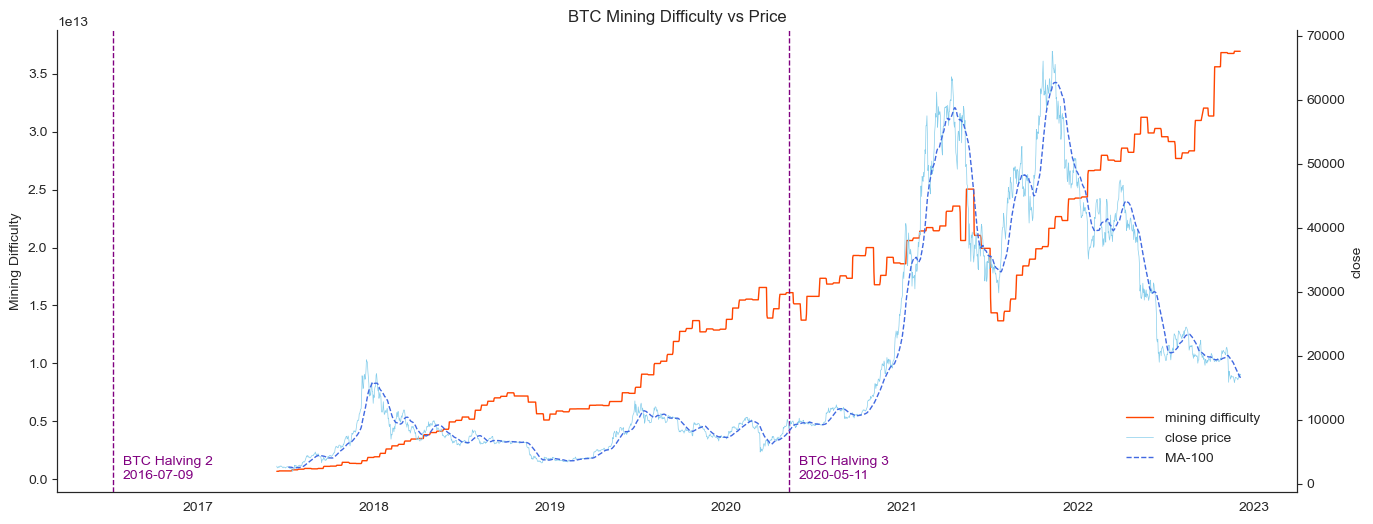

In [10]:
# Add a moving average
rolling_window = 25
coin_a_price_df['close_avg'] = coin_a_price_df['close'].rolling(window=rolling_window).mean() 

# Creating a Lineplot: Mining Difficulty vs Price
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df, x='date', y='difficulty', linewidth=1.0, color='orangered', ax=ax1, label=f'mining difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=coin_a_price_df, x='date', y='close', linewidth=0.5, color='skyblue', ax=ax2, label=f'close price')
sns.lineplot(data=coin_a_price_df, x='date', y='close_avg', linewidth=1.0, linestyle='--', color='royalblue', ax=ax2, label=f'MA-100')
add_twinx_legend(ax1, ax2, 0.98, 0.2)
add_halving_dates(ax1, onchain_symbol_a_df.date, onchain_symbol_a_df.hashrate)
ax1.set(xlabel=None)
ax1.set(ylabel='Mining Difficulty')
plt.title(f'{symbol_a} Mining Difficulty vs Price')
plt.show()

# Metric #5 Active Addresses compared to Bitcoin

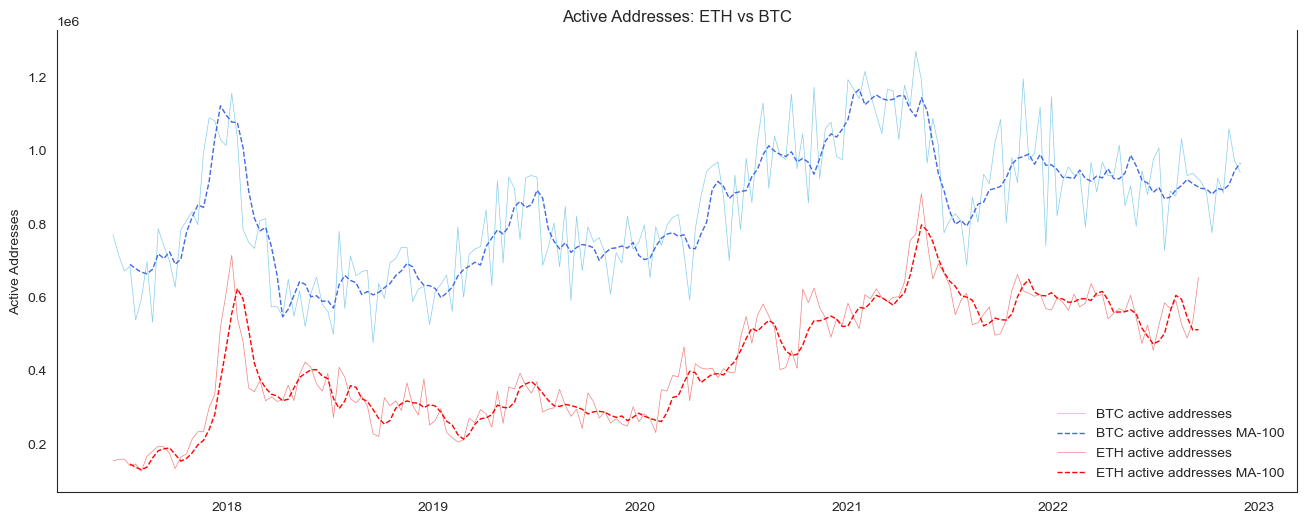

In [11]:
# Calculate active addresses moving average
rolling_window=25
y_a_add_ma = onchain_symbol_a_df['active_addresses'].rolling(window=rolling_window).mean() 
y_b_add_ma = onchain_symbol_b_df['active_addresses'].rolling(window=rolling_window).mean() 

# Lineplot: Active Addresses
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='active_addresses', 
    linewidth=0.5, color='skyblue', ax=ax1, label=f'{symbol_a} active addresses')
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y=y_a_add_ma, 
    linewidth=1.0, color='royalblue', linestyle='--', ax=ax1, label=f'{symbol_a} active addresses MA-{window}')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='active_addresses', 
    linewidth=0.5, color='lightcoral', ax=ax1, label=f'{symbol_b} active addresses')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y=y_b_add_ma, 
    linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{symbol_b} active addresses MA-{window}')
ax1.set(xlabel=None)
ax1.set(ylabel='Active Addresses')
plt.title(f'Active Addresses: {symbol_b} vs {symbol_a}')
plt.legend(framealpha=0)
plt.show()

# Metric #6 Transaction Count compared to Bitcoin

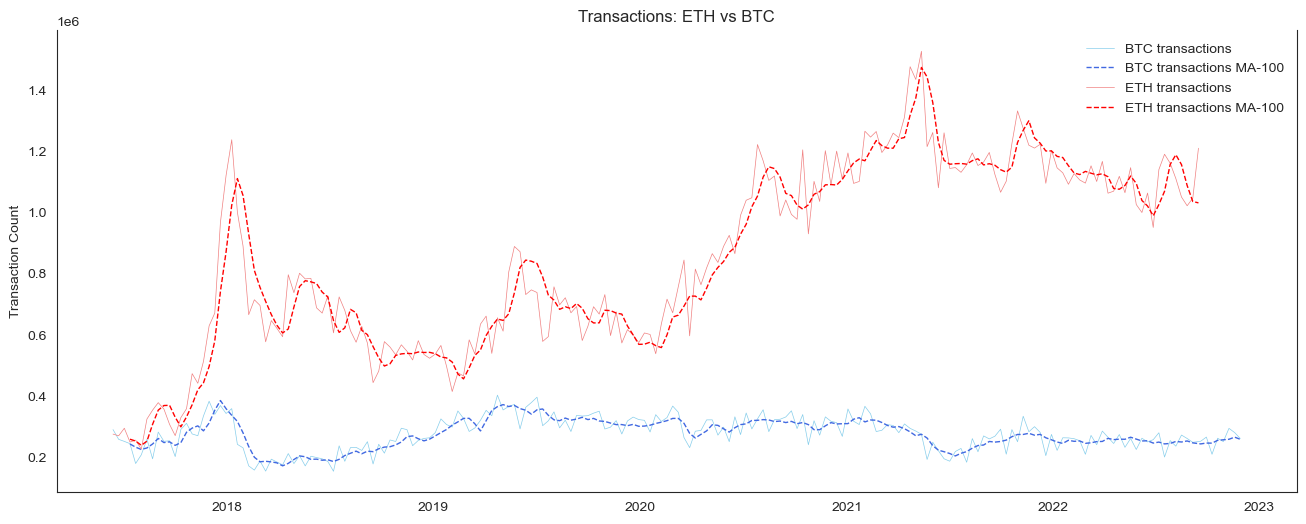

In [12]:
# Calculate Transaction Count Moving Averages
rolling_window=25
y_a_trx_ma = onchain_symbol_a_df['transaction_count'].rolling(window=rolling_window).mean() 
y_b_trx_ma = onchain_symbol_b_df['transaction_count'].rolling(window=rolling_window).mean() 

# Lineplot: Transactions Count
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='transaction_count', 
    linewidth=0.5, color='skyblue', ax=ax1, label=f'{symbol_a} transactions')
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y=y_a_trx_ma, 
    linewidth=1.0, color='royalblue', linestyle='--', ax=ax1, label=f'{symbol_a} transactions MA-{window}')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='transaction_count', 
    linewidth=0.5, color='lightcoral', ax=ax1, label=f'{symbol_b} transactions')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y=y_b_trx_ma, 
    linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{symbol_b} transactions MA-{window}')
ax1.set(xlabel=None)
ax1.set(ylabel='Transaction Count')
plt.legend(framealpha=0)
plt.title(f'Transactions: {symbol_b} vs {symbol_a}')
plt.show()

# Metric #7 Large Transactions compared to Bitcoin

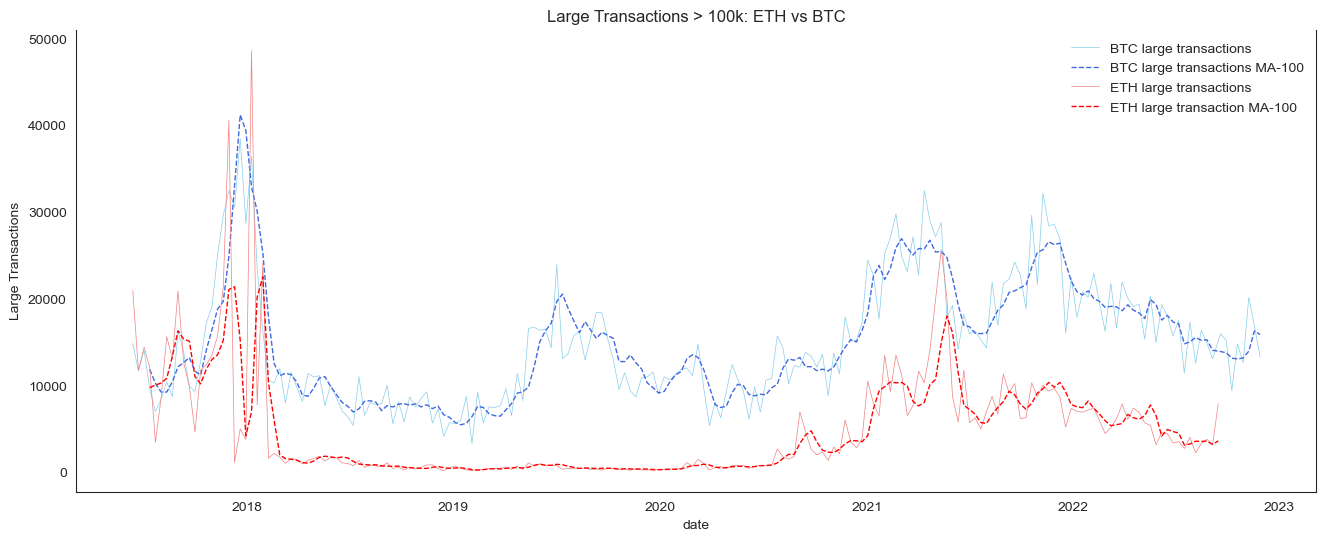

In [13]:
# Calculate Large Transactions Moving Averages
rolling_window=25
y_a_ltrx_ma = onchain_symbol_a_df['large_transaction_count'].rolling(window=rolling_window).mean() 
y_b_ltrx_ma = onchain_symbol_b_df['large_transaction_count'].rolling(window=rolling_window).mean() 

# Lineplot: Large Transactions
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='large_transaction_count', 
    linewidth=0.5, color='skyblue', ax=ax1, label=f'{symbol_a} large transactions')
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y=y_a_ltrx_ma, 
    linewidth=1.0, color='royalblue', linestyle='--', ax=ax1, label=f'{symbol_a} large transactions MA-{window}')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='large_transaction_count', 
    linewidth=0.5, color='lightcoral', ax=ax1, label=f'{symbol_b} large transactions')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y=y_b_ltrx_ma, 
    linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{symbol_b} large transaction MA-{window}')
ax1.set(ylabel='Large Transactions')
plt.title(f'Large Transactions > 100k: {symbol_b} vs {symbol_a}')
plt.legend(framealpha=0)
plt.show()